<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W2D4_DynamicNetworks/W2D4_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W2D4_DynamicNetworks/W2D4_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Bonus Tutorial: Extending the Wilson-Cowan Model
**Week 2, Day 4: Dynamic Networks**

**By Neuromatch Academy**

__Content creators:__ Qinglong Gu, Songtin Li, Arvind Kumar, John Murray, Julijana Gjorgjieva 

__Content reviewers:__ Maryam Vaziri-Pashkam, Ella Batty, Lorenzo Fontolan, Richard Gao, Spiros Chavlis, Michael Waskom

__Production editors:__ Siddharth Suresh

__Post-Production team:__ Gagana B, Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives
In the previous tutorial, you learned about the **Wilson-Cowan** rate model. Here we will dive into some deeper analyses of this model.

Bonus steps:

- Find and plot the **fixed points** of the Wilson-Cowan model.
- Investigate the stability of the Wilson-Cowan model by linearizing its dynamics and examining the **Jacobian matrix**.
- Learn how the Wilson-Cowan model can reach an oscillatory state.

Applications of Wilson-Cowan model:
- Visualize the behavior of an Inhibition-stabilized network.
- Simulate working memory using the Wilson-Cowan model.

<br>

Reference paper:

Wilson, H., and Cowan, J. (1972). Excitatory and inhibitory interactions in localized populations of model neurons. _Biophysical Journal_ **12**. doi: [10.1016/S0006-3495(72)86068-5](https://doi.org/10.1016/S0006-3495(72)86068-5)

---
# Setup

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt  # root-finding algorithm

In [2]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Plotting Functions

def plot_FI_inverse(x, a, theta):
  f, ax = plt.subplots()
  ax.plot(x, F_inv(x, a=a, theta=theta))
  ax.set(xlabel="$x$", ylabel="$F^{-1}(x)$")


def plot_FI_EI(x, FI_exc, FI_inh):
  plt.figure()
  plt.plot(x, FI_exc, 'b', label='E population')
  plt.plot(x, FI_inh, 'r', label='I population')
  plt.legend(loc='lower right')
  plt.xlabel('x (a.u.)')
  plt.ylabel('F(x)')
  plt.show()


def my_test_plot(t, rE1, rI1, rE2, rI2):

  plt.figure()
  ax1 = plt.subplot(211)
  ax1.plot(pars['range_t'], rE1, 'b', label='E population')
  ax1.plot(pars['range_t'], rI1, 'r', label='I population')
  ax1.set_ylabel('Activity')
  ax1.legend(loc='best')

  ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
  ax2.plot(pars['range_t'], rE2, 'b', label='E population')
  ax2.plot(pars['range_t'], rI2, 'r', label='I population')
  ax2.set_xlabel('t (ms)')
  ax2.set_ylabel('Activity')
  ax2.legend(loc='best')

  plt.tight_layout()
  plt.show()


def plot_nullclines(Exc_null_rE, Exc_null_rI, Inh_null_rE, Inh_null_rI):

  plt.figure()
  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')
  plt.show()


def my_plot_nullcline(pars):
  Exc_null_rE = np.linspace(-0.01, 0.96, 100)
  Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
  Inh_null_rI = np.linspace(-.01, 0.8, 100)
  Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')


def my_plot_vector(pars, my_n_skip=2, myscale=5):
  EI_grid = np.linspace(0., 1., 20)
  rE, rI = np.meshgrid(EI_grid, EI_grid)
  drEdt, drIdt = EIderivs(rE, rI, **pars)

  n_skip = my_n_skip

  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=myscale, facecolor='c')

  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def my_plot_trajectory(pars, mycolor, x_init, mylabel):
  pars = pars.copy()
  pars['rE_init'], pars['rI_init'] = x_init[0], x_init[1]
  rE_tj, rI_tj = simulate_wc(**pars)

  plt.plot(rE_tj, rI_tj, color=mycolor, label=mylabel)
  plt.plot(x_init[0], x_init[1], 'o', color=mycolor, ms=8)
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def my_plot_trajectories(pars, dx, n, mylabel):
  """
  Solve for I along the E_grid from dE/dt = 0.

  Expects:
  pars    : Parameter dictionary
  dx      : increment of initial values
  n       : n*n trjectories
  mylabel : label for legend

  Returns:
    figure of trajectory
  """
  pars = pars.copy()
  for ie in range(n):
    for ii in range(n):
      pars['rE_init'], pars['rI_init'] = dx * ie, dx * ii
      rE_tj, rI_tj = simulate_wc(**pars)
      if (ie == n-1) & (ii == n-1):
          plt.plot(rE_tj, rI_tj, 'gray', alpha=0.8, label=mylabel)
      else:
          plt.plot(rE_tj, rI_tj, 'gray', alpha=0.8)

  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def plot_complete_analysis(pars):
  plt.figure(figsize=(7.7, 6.))

  # plot example trajectories
  my_plot_trajectories(pars, 0.2, 6,
                       'Sample trajectories \nfor different init. conditions')
  my_plot_trajectory(pars, 'orange', [0.6, 0.8],
                     'Sample trajectory for \nlow activity')
  my_plot_trajectory(pars, 'm', [0.6, 0.6],
                     'Sample trajectory for \nhigh activity')

  # plot nullclines
  my_plot_nullcline(pars)

  # plot vector field
  EI_grid = np.linspace(0., 1., 20)
  rE, rI = np.meshgrid(EI_grid, EI_grid)
  drEdt, drIdt = EIderivs(rE, rI, **pars)
  n_skip = 2
  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=5., facecolor='c')

  plt.legend(loc=[1.02, 0.57], handlelength=1)
  plt.show()


def plot_fp(x_fp, position=(0.02, 0.1), rotation=0):
  plt.plot(x_fp[0], x_fp[1], 'ko', ms=8)
  plt.text(x_fp[0] + position[0], x_fp[1] + position[1],
           f'Fixed Point1=\n({x_fp[0]:.3f}, {x_fp[1]:.3f})',
           horizontalalignment='center', verticalalignment='bottom',
           rotation=rotation)

In [4]:
# @title Helper functions


def default_pars(**kwargs):
  pars = {}

  # Excitatory parameters
  pars['tau_E'] = 1.     # Timescale of the E population [ms]
  pars['a_E'] = 1.2      # Gain of the E population
  pars['theta_E'] = 2.8  # Threshold of the E population

  # Inhibitory parameters
  pars['tau_I'] = 2.0    # Timescale of the I population [ms]
  pars['a_I'] = 1.0      # Gain of the I population
  pars['theta_I'] = 4.0  # Threshold of the I population

  # Connection strength
  pars['wEE'] = 9.   # E to E
  pars['wEI'] = 4.   # I to E
  pars['wIE'] = 13.  # E to I
  pars['wII'] = 11.  # I to I

  # External input
  pars['I_ext_E'] = 0.
  pars['I_ext_I'] = 0.

  # simulation parameters
  pars['T'] = 50.        # Total duration of simulation [ms]
  pars['dt'] = .1        # Simulation time step [ms]
  pars['rE_init'] = 0.2  # Initial value of E
  pars['rI_init'] = 0.2  # Initial value of I

  # External parameters if any
  for k in kwargs:
      pars[k] = kwargs[k]

  # Vector of discretized time points [ms]
  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

  return pars


def F(x, a, theta):
  """
  Population activation function, F-I curve

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    f     : the population activation response f(x) for input x
  """

  # add the expression of f = F(x)
  f = (1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1

  return f


def dF(x, a, theta):
  """
  Derivative of the population activation function.

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    dFdx  :  Derivative of the population activation function.
  """

  dFdx = a * np.exp(-a * (x - theta)) * (1 + np.exp(-a * (x - theta)))**-2

  return dFdx

def F_inv(x, a, theta):
  """
  Args:
    x         : the population input
    a         : the gain of the function
    theta     : the threshold of the function

  Returns:
    F_inverse : value of the inverse function
  """

  # Calculate Finverse (ln(x) can be calculated as np.log(x))
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta

  return F_inverse


def get_E_nullcline(rE, a_E, theta_E, wEE, wEI, I_ext_E, **other_pars):
  """
  Solve for rI along the rE from drE/dt = 0.

  Args:
    rE    : response of excitatory population
    a_E, theta_E, wEE, wEI, I_ext_E : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  # calculate rI for E nullclines on rI
  rI = 1 / wEI * (wEE * rE - F_inv(rE, a_E, theta_E) + I_ext_E)

  return rI


def get_I_nullcline(rI, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  """
  Solve for E along the rI from dI/dt = 0.

  Args:
    rI    : response of inhibitory population
    a_I, theta_I, wIE, wII, I_ext_I : Wilson-Cowan inhibitory parameters
    Other parameters are ignored

  Returns:
    rE    : values of the excitatory population along the nullcline on the rI
  """
  # calculate rE for I nullclines on rI
  rE = 1 / wIE * (wII * rI + F_inv(rI, a_I, theta_I) - I_ext_I)

  return rE

def EIderivs(rE, rI,
             tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
             tau_I, a_I, theta_I, wIE, wII, I_ext_I,
             **other_pars):
  """Time derivatives for E/I variables (dE/dt, dI/dt)."""

  # Compute the derivative of rE
  drEdt = (-rE + F(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

  # Compute the derivative of rI
  drIdt = (-rI + F(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

  return drEdt, drIdt

def simulate_wc(tau_E, a_E, theta_E, tau_I, a_I, theta_I,
                wEE, wEI, wIE, wII, I_ext_E, I_ext_I,
                rE_init, rI_init, dt, range_t, **other_pars):
  """
  Simulate the Wilson-Cowan equations

  Args:
    Parameters of the Wilson-Cowan model

  Returns:
    rE, rI (arrays) : Activity of excitatory and inhibitory populations
  """
  # Initialize activity arrays
  Lt = range_t.size
  rE = np.append(rE_init, np.zeros(Lt - 1))
  rI = np.append(rI_init, np.zeros(Lt - 1))
  I_ext_E = I_ext_E * np.ones(Lt)
  I_ext_I = I_ext_I * np.ones(Lt)

  # Simulate the Wilson-Cowan equations
  for k in range(Lt - 1):

    # Calculate the derivative of the E population
    drE = dt / tau_E * (-rE[k] + F(wEE * rE[k] - wEI * rI[k] + I_ext_E[k],
                                   a_E, theta_E))

    # Calculate the derivative of the I population
    drI = dt / tau_I * (-rI[k] + F(wIE * rE[k] - wII * rI[k] + I_ext_I[k],
                                   a_I, theta_I))

    # Update using Euler's method
    rE[k + 1] = rE[k] + drE
    rI[k + 1] = rI[k] + drI

  return rE, rI

The helper functions included:

- Parameter dictionary: `default_pars(**kwargs)`. You can use:
  - `pars = default_pars()` to get all the parameters, and then you can execute `print(pars)` to check these parameters. 
  - `pars = default_pars(T=T_sim, dt=time_step)` to set a different simulation time and time step
  - After `pars = default_pars()`, use `par['New_para'] = value` to add a new parameter with its value
  - Pass to functions that accept individual parameters with `func(**pars)`
- F-I curve: `F(x, a, theta)`
- Derivative of the F-I curve: `dF(x, a, theta)`
- Inverse of F-I curve: `F_inv`
- Nullcline calculations: `get_E_nullcline`, `get_I_nullcline`
- Derivatives of E/I variables: `EIderivs`
- Simulate the Wilson-Cowan model: `simulate_wc`

---
# Section 1: Fixed points, stability analysis, and limit cycles in the Wilson-Cowan model

*Correction to video: this is now the first part of the second bonus tutorial, not the last part of the second tutorial*

In [5]:
# @title Video 1: Fixed points and their stability
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Pf4y1d7dx", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="jIx26iQ69ps", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

As in Tutorial 2, we will be looking at the Wilson-Cowan model, with coupled equations representing the dynamics of the excitatory or inhibitory population:

\begin{align}
\tau_E \frac{dr_E}{dt} &= -r_E + F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a_E,\theta_E) \\
\tau_I \frac{dr_I}{dt} &= -r_I + F_I(w_{IE}r_E -w_{II}r_I + I^{\text{ext}}_I;a_I,\theta_I) \qquad (1)
\end{align}

$r_E(t)$ represents the average activation (or firing rate) of the excitatory population at time $t$, and $r_I(t)$ the activation (or firing rate) of the inhibitory population. The parameters $\tau_E$ and $\tau_I$ control the timescales of the dynamics of each population. Connection strengths are given by: $w_{EE}$ (E $\rightarrow$ E), $w_{EI}$ (I $\rightarrow$ E), $w_{IE}$ (E $\rightarrow$ I), and $w_{II}$ (I $\rightarrow$ I). The terms $w_{EI}$ and $w_{IE}$ represent connections from inhibitory to excitatory population and vice versa, respectively. The transfer functions (or F-I curves) $F_E(x;a_E,\theta_E)$ and $F_I(x;a_I,\theta_I)$ can be different for the excitatory and the inhibitory populations.

## Section 1.1: Fixed Points of the E/I system

The intersection points of the two nullcline curves are the fixed points of the Wilson-Cowan model in Equation $(1)$. 

In the next exercise, we will find the coordinate of all fixed points for a given set of parameters.

We'll make use of two functions, similar to ones we saw in Tutorial 1, which use a root-finding algorithm to find the fixed points of the system with Excitatory and Inhibitory populations.

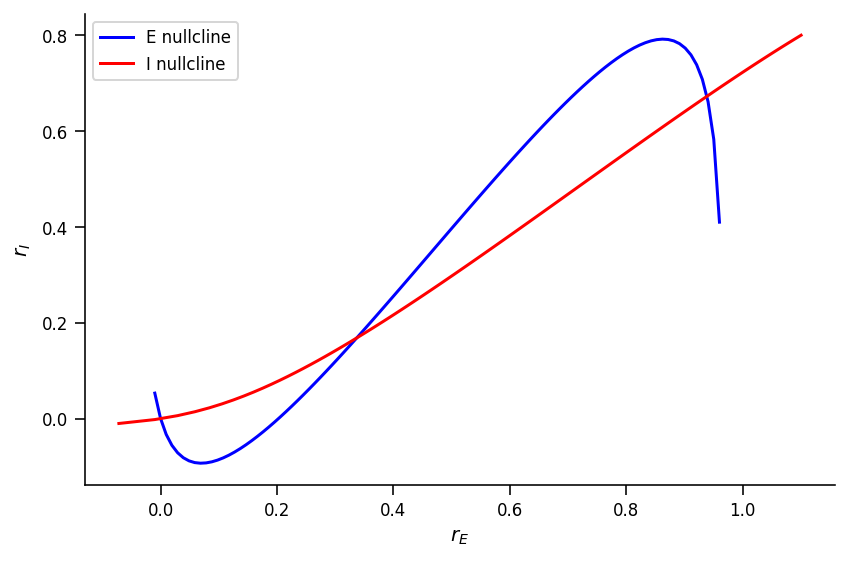

In [6]:
# @markdown Execute to visualize nullclines

# Set parameters
pars = default_pars()
Exc_null_rE = np.linspace(-0.01, 0.96, 100)
Inh_null_rI = np.linspace(-.01, 0.8, 100)

# Compute nullclines
Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

plot_nullclines(Exc_null_rE, Exc_null_rI, Inh_null_rE, Inh_null_rI)

In [7]:
# @markdown *Execute the cell to define `my_fp` and `check_fp`*

def my_fp(pars, rE_init, rI_init):
  """
  Use opt.root function to solve Equations (2)-(3) from initial values
  """

  tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
  tau_I, a_I, theta_I = pars['tau_I'], pars['a_I'], pars['theta_I']
  wEE, wEI = pars['wEE'], pars['wEI']
  wIE, wII = pars['wIE'], pars['wII']
  I_ext_E, I_ext_I = pars['I_ext_E'], pars['I_ext_I']

  # define the right hand of wilson-cowan equations
  def my_WCr(x):

    rE, rI = x
    drEdt = (-rE + F(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E
    drIdt = (-rI + F(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I
    y = np.array([drEdt, drIdt])

    return y

  x0 = np.array([rE_init, rI_init])
  x_fp = opt.root(my_WCr, x0).x

  return x_fp


def check_fp(pars, x_fp, mytol=1e-6):
  """
  Verify (drE/dt)^2 + (drI/dt)^2< mytol

  Args:
    pars    : Parameter dictionary
    fp      : value of fixed point
    mytol   : tolerance, default as 10^{-6}

  Returns :
    Whether it is a correct fixed point: True/False
  """

  drEdt, drIdt = EIderivs(x_fp[0], x_fp[1], **pars)

  return drEdt**2 + drIdt**2 < mytol

help(my_fp)

Help on function my_fp in module __main__:

my_fp(pars, rE_init, rI_init)
    Use opt.root function to solve Equations (2)-(3) from initial values



### Coding Exercise 1.1: Find the fixed points of the Wilson-Cowan model

From the above nullclines, we notice that the system features  three fixed points with the parameters we used. To find their coordinates, we need to choose a proper initial value to give to the `opt.root` function inside of the function `my_fp` we just defined, since the algorithm can only find fixed points in the vicinity of the initial value. 

In this exercise, you will use the function `my_fp` to find each of the fixed points by varying the initial values. Note that you can choose the values near the intersections of the nullclines as the initial values to calculate the fixed points.

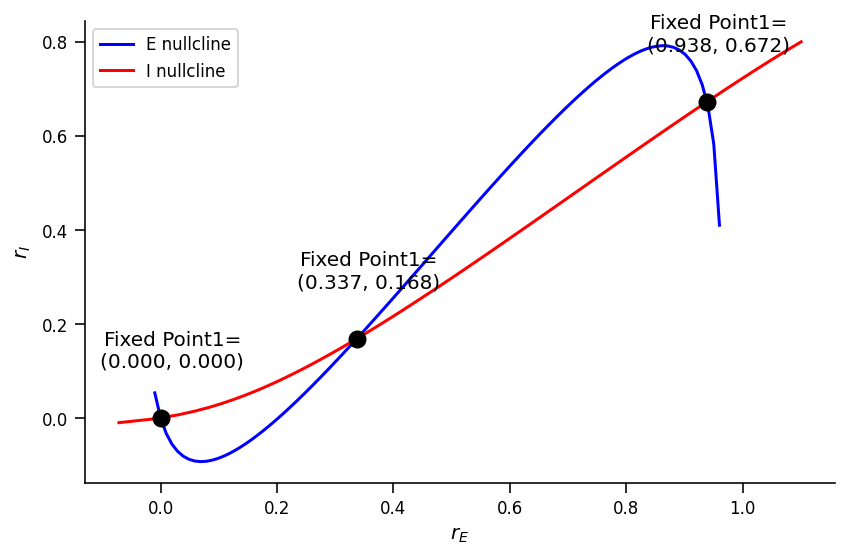

In [8]:
pars = default_pars()

######################################################################

# Check if x_fp's are the correct with the function check_fp(x_fp)
# Hint: vary different initial values to find the correct fixed points

######################################################################

my_plot_nullcline(pars)

# Find the first fixed point
x_fp_1 = my_fp(pars, 0.1, 0.1)
if check_fp(pars, x_fp_1):
  plot_fp(x_fp_1)

# Find the second fixed point
x_fp_2 = my_fp(pars, 0.4, 0.4)
if check_fp(pars, x_fp_2):
  plot_fp(x_fp_2)

# Find the third fixed point
x_fp_3 = my_fp(pars, 0.9, 0.9)
if check_fp(pars, x_fp_3):
  plot_fp(x_fp_3)

## Section 1.2: Stability of a fixed point and eigenvalues of the Jacobian Matrix

First, let's first rewrite the system $1$ as:

\begin{align}
\frac{dr_E}{dt} &= G_E(r_E,r_I) \\
\frac{dr_I}{dt} &= G_I(r_E,r_I)
\end{align}

where

\begin{align}
G_E(r_E,r_I) &= \frac{1}{\tau_E} [-r_E + F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a,\theta)] \\
G_I(r_E,r_I) &= \frac{1}{\tau_I} [-r_I + F_I(w_{IE}r_E -w_{II}r_I + I^{\text{ext}}_I;a,\theta)]
\end{align}

By definition, $\displaystyle\frac{dr_E}{dt}=0$ and $\displaystyle\frac{dr_I}{dt}=0$ at each fixed point. Therefore, if the initial state is exactly at the fixed point, the state of the system will not change as time evolves. 

However, if the initial state deviates slightly from the fixed point, there are two possibilities
the trajectory will be attracted back to the 

1. The trajectory will be attracted back to the fixed point
2. The trajectory will diverge from the fixed point. 

These two possibilities define the type of fixed point, i.e., stable or unstable. Similar to the 1D system studied in the previous tutorial, the stability of a fixed point $(r_E^*, r_I^*)$ can be determined by linearizing the dynamics of the system (can you figure out how?). The linearization will yield a matrix of first-order derivatives called the Jacobian matrix:

\begin{equation}
J=
\left[ {\begin{array}
  \displaystyle{\frac{\partial}{\partial r_E}}G_E(r_E^*, r_I^*) & \displaystyle{\frac{\partial}{\partial r_I}}G_E(r_E^*, r_I^*)\\[1mm]
  \displaystyle\frac{\partial}{\partial r_E} G_I(r_E^*, r_I^*) & \displaystyle\frac{\partial}{\partial r_I}G_I(r_E^*, r_I^*) \\
\end{array} } \right] \quad (7)
\end{equation}

<br>

The eigenvalues of the Jacobian matrix calculated at the fixed point will determine whether it is a stable or unstable fixed point.

We can now compute the derivatives needed to build the Jacobian matrix. Using the chain and product rules the derivatives for the excitatory population are given by:

<br>

\begin{align}
\frac{\partial}{\partial r_E} G_E(r_E^*, r_I^*) &= \frac{1}{\tau_E} [-1 + w_{EE} F_E'(w_{EE}r_E^* -w_{EI}r_I^* +  I^{\text{ext}}_E;\alpha_E, \theta_E)] \\[1mm]
\frac{\partial}{\partial r_I} G_E(r_E^*, r_I^*) &= \frac{1}{\tau_E} [-w_{EI} F_E'(w_{EE}r_E^* -w_{EI}r_I^* +  I^{\text{ext}}_E;\alpha_E, \theta_E)]
\end{align}

<br>

The same applies to the inhibitory population. 

### Coding Exercise 1.2: Compute the Jacobian Matrix for the Wilson-Cowan model

Here, you can use `dF(x,a,theta)` defined in the `Helper functions` to calculate the derivative of the F-I curve.

In [9]:
def get_eig_Jacobian(fp,
                     tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
                     tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  """Compute eigenvalues of the Wilson-Cowan Jacobian matrix at fixed point."""
  # Initialization
  rE, rI = fp
  J = np.zeros((2, 2))

  ###########################################################################
  ###########################################################################
  # Compute the four elements of the Jacobian matrix
  J[0, 0] = (1/tau_E)*(-1 + wEE * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E))
  J[0, 1] = (1/tau_E)*(-wEI * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E))
  J[1, 0] = (1/tau_I)*(wIE * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I))
  J[1, 1] = (1/tau_I)*(-1 - wII * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I))

  # Compute and return the eigenvalues
  evals = np.linalg.eig(J)[0]
  return evals


# Compute eigenvalues of Jacobian
eig_1 = get_eig_Jacobian(x_fp_1, **pars)
eig_2 = get_eig_Jacobian(x_fp_2, **pars)
eig_3 = get_eig_Jacobian(x_fp_3, **pars)

print(eig_1, 'Stable point')
print(eig_2, 'Unstable point')
print(eig_3, 'Stable point')

[-0.62338386+0.13110957j -0.62338386-0.13110957j] Stable point
[ 1.05720798 -0.87266898] Unstable point
[-0.95956219 -1.42197413] Stable point


As is evident, the stable fixed points correspond to the negative eigenvalues, while unstable points correspond to at least one positive eigenvalue.

The sign of the eigenvalues is determined by the connectivity (interaction) between excitatory and inhibitory populations. 

Below we investigate the effect of $w_{EE}$ on the nullclines and the eigenvalues of the dynamical system. 

\* _Critical change is referred to as **pitchfork bifurcation**_. 

## Section 1.3: Effect of `wEE` on the nullclines and the eigenvalues

### Interactive Demo 1.3: Nullclines position in the phase plane changes with parameter values

How do the nullclines move for different values of the parameter $w_{EE}$? What does this mean for fixed points and system activity?

In [10]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def plot_nullcline_diffwEE(wEE):
  """
    plot nullclines for different values of wEE
  """

  pars = default_pars(wEE=wEE)

  # plot the E, I nullclines
  Exc_null_rE = np.linspace(-0.01, .96, 100)
  Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)

  Inh_null_rI = np.linspace(-.01, .8, 100)
  Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

  plt.figure(figsize=(12, 5.5))
  plt.subplot(121)
  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')

  plt.subplot(222)
  pars['rE_init'], pars['rI_init'] = 0.2, 0.2
  rE, rI = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE, 'b', label='E population', clip_on=False)
  plt.plot(pars['range_t'], rI, 'r', label='I population', clip_on=False)
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.ylim(-0.05, 1.05)
  plt.title('E/I activity\nfor different initial conditions',
            fontweight='bold')

  plt.subplot(224)
  pars['rE_init'], pars['rI_init'] = 0.4, 0.1
  rE, rI = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE, 'b', label='E population', clip_on=False)
  plt.plot(pars['range_t'], rI, 'r', label='I population', clip_on=False)
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.ylim(-0.05, 1.05)

  plt.tight_layout()
  plt.show()


_ = widgets.interact(plot_nullcline_diffwEE, wEE=(6., 10., .01))

interactive(children=(FloatSlider(value=8.0, description='wEE', max=10.0, min=6.0, step=0.01), Output()), _dom…

In [11]:
# to_remove explanation

"""

- For low values of wEE there is only one fixed point and it is stable so initial
conditions do not matter and the system always converge to the only fixed point

- For high values of wEE we have three fixed points of which two are stable and
one is unstable (or saddle). Now it matters where the initial conditions are. If
the initial conditions are in the attractor region os the high activity fixed
point then the system will converge to that (the bottom example).
""";

We can also investigate the effect of different $w_{EI}$, $w_{IE}$, $w_{II}$, $\tau_{E}$, $\tau_{I}$, and $I_{E}^{\text{ext}}$ on the stability of fixed points. In addition, we can also consider the perturbation of the parameters of the gain curve $F(\cdot)$.

## Section 1.4: Limit cycle - Oscillations

For some values of interaction terms ($w_{EE}, w_{IE}, w_{EI}, w_{II}$), the eigenvalues can become complex. When at least one pair of eigenvalues is complex, oscillations arise. 
The stability of oscillations is determined by the real part of the eigenvalues (+ve real part oscillations will grow, -ve real part oscillations will die out). The size of the complex part determines the frequency of oscillations. 

For instance, if we use a different set of parameters, $w_{EE}=6.4$, $w_{EI}=4.8$, $w_{IE}=6.$, $w_{II}=1.2$, and $I_{E}^{\text{ext}}=0.8$, then we shall observe that the E and I population activity start to oscillate! Please execute the cell below to check the oscillatory behavior. 

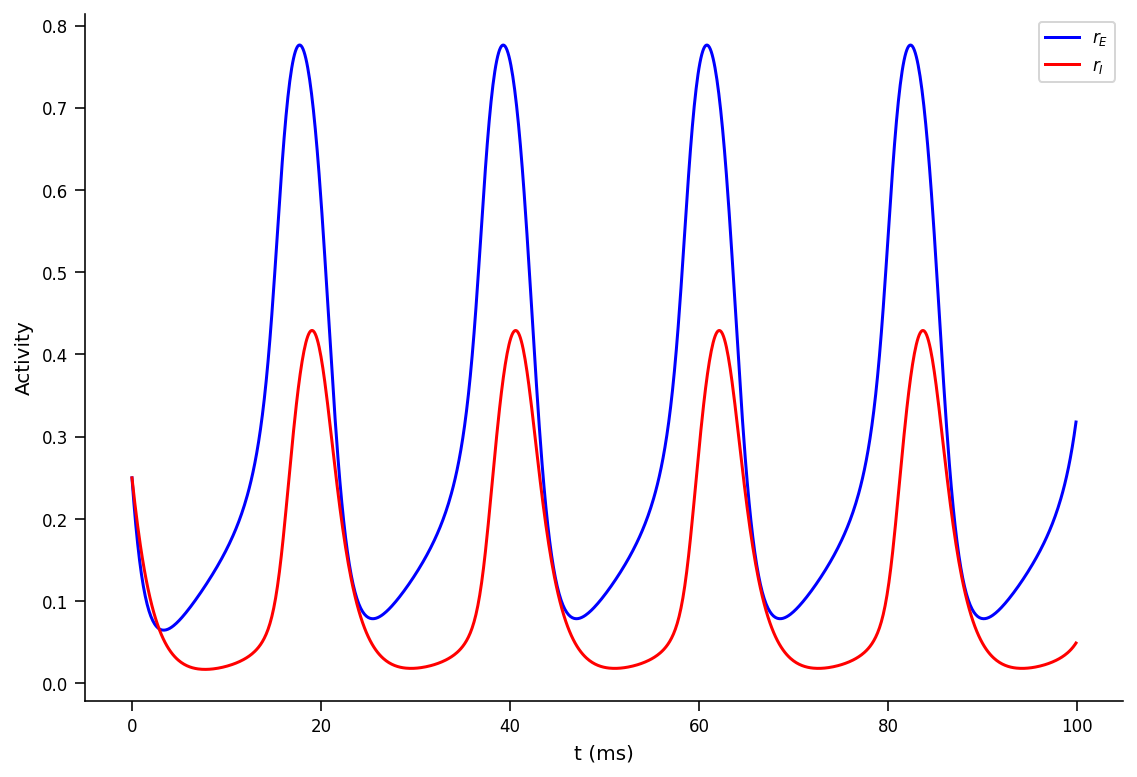

In [12]:
# @title

# @markdown Make sure you execute this cell to see the oscillations!

pars = default_pars(T=100.)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8
pars['rE_init'], pars['rI_init'] = 0.25, 0.25

rE, rI = simulate_wc(**pars)
plt.figure(figsize=(8, 5.5))
plt.plot(pars['range_t'], rE, 'b', label=r'$r_E$')
plt.plot(pars['range_t'], rI, 'r', label=r'$r_I$')
plt.xlabel('t (ms)')
plt.ylabel('Activity')
plt.legend(loc='best')
plt.show()

We can also understand the oscillations of the population behavior using the phase plane. By plotting a set of trajectories with different initial states, we can see that these trajectories will move in a circle instead of converging to a fixed point. This circle is called "limit cycle" and shows the periodic oscillations of the $E$ and $I$ population behavior under some conditions.

Let's plot the phase plane using the previously defined functions.

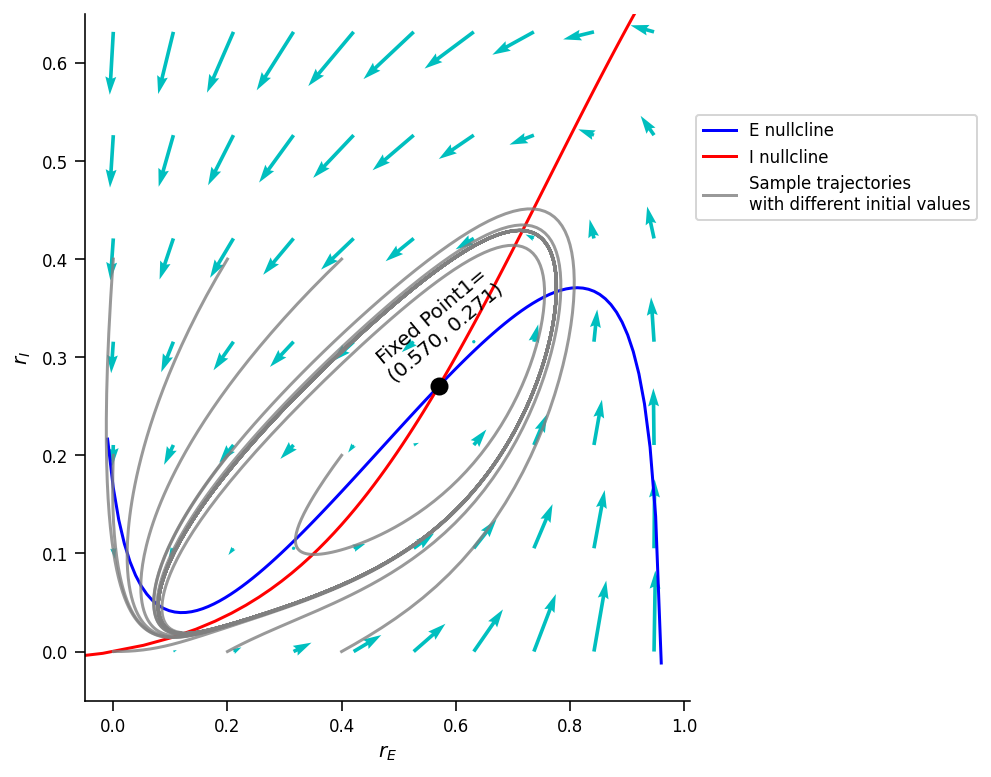

In [13]:
# @markdown Execute to visualize phase plane

pars = default_pars(T=100.)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8


plt.figure(figsize=(7, 5.5))
my_plot_nullcline(pars)

# Find the correct fixed point
x_fp_1 = my_fp(pars, 0.8, 0.8)
if check_fp(pars, x_fp_1):
  plot_fp(x_fp_1, position=(0, 0), rotation=40)

my_plot_trajectories(pars, 0.2, 3,
                      'Sample trajectories \nwith different initial values')

my_plot_vector(pars)

plt.legend(loc=[1.01, 0.7])
plt.xlim(-0.05, 1.01)
plt.ylim(-0.05, 0.65)
plt.show()

### Interactive Demo 1.4: Limit cycle and oscillations.

From the above examples, the change of model parameters changes the shape of the nullclines and, accordingly, the behavior of the $E$ and $I$ populations from steady fixed points to oscillations. However, the shape of the nullclines is unable to fully determine the behavior of the network. The vector field also matters. To demonstrate this, here, we will investigate the effect of time constants on the population behavior. By changing the inhibitory time constant $\tau_I$, the nullclines do not change, but the network behavior changes substantially from steady state to oscillations with different frequencies. 

Such a dramatic change in the system behavior is referred to as a **bifurcation**. 

\\
Please execute the code below to check this out.

In [14]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def time_constant_effect(tau_i=0.5):

  pars = default_pars(T=100.)
  pars['wEE'], pars['wEI'] = 6.4, 4.8
  pars['wIE'], pars['wII'] = 6.0, 1.2
  pars['I_ext_E'] = 0.8

  pars['tau_I'] = tau_i

  Exc_null_rE = np.linspace(0.0, .9, 100)
  Inh_null_rI = np.linspace(0.0, .6, 100)

  Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
  Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

  plt.figure(figsize=(12.5, 5.5))

  plt.subplot(121)  # nullclines
  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline', zorder=2)
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline', zorder=2)
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')

  # fixed point
  x_fp_1 = my_fp(pars, 0.5, 0.5)
  plt.plot(x_fp_1[0], x_fp_1[1], 'ko', zorder=2)

  eig_1 = get_eig_Jacobian(x_fp_1, **pars)

  # trajectories
  for ie in range(5):
    for ii in range(5):
      pars['rE_init'], pars['rI_init'] = 0.1 * ie, 0.1 * ii
      rE_tj, rI_tj = simulate_wc(**pars)
      plt.plot(rE_tj, rI_tj, 'k', alpha=0.3, zorder=1)

  # vector field
  EI_grid_E = np.linspace(0., 1.0, 20)
  EI_grid_I = np.linspace(0., 0.6, 20)
  rE, rI = np.meshgrid(EI_grid_E, EI_grid_I)
  drEdt, drIdt = EIderivs(rE, rI, **pars)
  n_skip = 2
  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
              drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
              angles='xy', scale_units='xy', scale=10, facecolor='c')
  plt.title(r'$\tau_I=$'+'%.1f ms' % tau_i)

  plt.subplot(122)  # sample E/I trajectories
  pars['rE_init'], pars['rI_init'] = 0.25, 0.25
  rE, rI = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE, 'b', label=r'$r_E$')
  plt.plot(pars['range_t'], rI, 'r', label=r'$r_I$')
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.title(r'$\tau_I=$'+'%.1f ms' % tau_i)
  plt.legend(loc='best')
  plt.tight_layout()
  plt.show()


_ = widgets.interact(time_constant_effect, tau_i=(0.2, 3, .1))

interactive(children=(FloatSlider(value=0.5, description='tau_i', max=3.0, min=0.2), Output()), _dom_classes=(…

Both $\tau_E$ and $\tau_I$ feature in the Jacobian of the two population network (eq 7). So here is seems that the by increasing $\tau_I$ the eigenvalues corresponding to the stable fixed point are becoming complex.

Intuitively, when $\tau_I$ is smaller, inhibitory activity changes faster than excitatory activity. As inhibition exceeds above a certain value, high inhibition inhibits excitatory population but that in turns means that inhibitory population gets smaller input (from the exc. connection). So inhibition decreases rapidly. But this means that excitation recovers -- and so on ...

---
# Section 2: Inhibition-stabilized network (ISN)


## Section 2.1: Inhibition-stabilized network

As described above, one can obtain the linear approximation around the fixed point as 

\begin{equation}
\frac{d}{dr} \vec{R} =
\left[ {\begin{array}
\displaystyle{\frac{\partial G_E}{\partial r_E}} & \displaystyle{\frac{\partial G_E}{\partial r_I}} \\
\displaystyle\frac{\partial G_I}{\partial r_E} & \displaystyle\frac{\partial G_I}{\partial r_I} \\
\end{array} } \right] \vec{R},
\end{equation}

<br>

where $\vec{R} = [r_E, r_I]^{\rm T}$ is the vector of the E/I activity.

Let's direct our attention to the excitatory subpopulation which follows:

<br>

\begin{equation}
\frac{dr_E}{dt} = \frac{\partial G_E}{\partial r_E}\cdot r_E + \frac{\partial G_E}{\partial r_I} \cdot r_I
\end{equation}

<br>

Recall that, around fixed point $(r_E^*, r_I^*)$:

<br>

\begin{align}
\frac{\partial}{\partial r_E}G_E(r_E^*, r_I^*) &= \frac{1}{\tau_E} [-1 + w_{EE} F'_{E}(w_{EE}r_E^* -w_{EI}r_I^* + I^{\text{ext}}_E; \alpha_E, \theta_E)] &\qquad (8) \\
\frac{\partial}{\partial r_I}G_E(r_E^*, r_I^*) &= \frac{1}{\tau_E} [-w_{EI} F'_{E}(w_{EE}r_E^* -w_{EI}r_I^* + I^{\text{ext}}_E; \alpha_E, \theta_E)] &\qquad (9)\\
\frac{\partial}{\partial r_E}G_I(r_E^*, r_I^*) &= \frac{1}{\tau_I} [w_{IE} F'_{I}(w_{IE}r_E^* -w_{II}r_I^* + I^{\text{ext}}_I; \alpha_I, \theta_I)] &\qquad (10) \\
\frac{\partial}{\partial r_I}G_I(r_E^*, r_I^*) &= \frac{1}{\tau_I} [-1-w_{II} F'_{I}(w_{IE}r_E^* -w_{II}r_I^* + I^{\text{ext}}_I; \alpha_I, \theta_I)] &\qquad (11)
\end{align}

<br>

From Equation. (8), it is clear that $\displaystyle{\frac{\partial G_E}{\partial r_I}}$ is negative since the $\displaystyle{\frac{dF}{dx}}$ is always positive. It can be understood by that the recurrent inhibition from the inhibitory activity ($I$) can reduce the excitatory ($E$) activity. However, as described above, $\displaystyle{\frac{\partial G_E}{\partial r_E}}$ has negative terms related to the "leak" effect, and positive terms related to the recurrent excitation. Therefore, it leads to two different regimes:

- $\displaystyle{\frac{\partial}{\partial r_E}G_E(r_E^*, r_I^*)}<0$, **noninhibition-stabilized
network (non-ISN) regime**

- $\displaystyle{\frac{\partial}{\partial r_E}G_E(r_E^*, r_I^*)}>0$, **inhibition-stabilized
network (ISN) regime**

### Coding Exercise 2.1: Compute $\displaystyle{\frac{\partial G_E}{\partial r_E}}$

Implement the function to calculate the $\displaystyle{\frac{\partial G_E}{\partial r_E}}$ for the default parameters, and the parameters of the limit cycle case.

In [15]:
def get_dGdE(fp, tau_E, a_E, theta_E, wEE, wEI, I_ext_E, **other_pars):
  """
  Compute dGdE

  Args:
    fp   : fixed point (E, I), array
    Other arguments are parameters of the Wilson-Cowan model

  Returns:
    J    : the 2x2 Jacobian matrix
  """
  rE, rI = fp

  # Calculate the J[0,0]
  dGdrE = (1/tau_E)*(-1 + wEE * dF(wEE*rE - wEI * rI +I_ext_E, a_E, theta_E))

  return dGdrE


# Get fixed points
pars = default_pars()
x_fp_1 = my_fp(pars, 0.1, 0.1)
x_fp_2 = my_fp(pars, 0.3, 0.3)
x_fp_3 = my_fp(pars, 0.8, 0.6)

# Compute dGdE
dGdrE1 = get_dGdE(x_fp_1, **pars)
dGdrE2 = get_dGdE(x_fp_2, **pars)
dGdrE3 = get_dGdE(x_fp_3, **pars)

print(f'For the default case:')
print(f'dG/drE(fp1) = {dGdrE1:.3f}')
print(f'dG/drE(fp2) = {dGdrE2:.3f}')
print(f'dG/drE(fp3) = {dGdrE3:.3f}')

print('\n')

pars = default_pars(wEE=6.4, wEI=4.8, wIE=6.0, wII=1.2, I_ext_E=0.8)
x_fp_lc = my_fp(pars, 0.8, 0.8)

dGdrE_lc = get_dGdE(x_fp_lc, **pars)

print('For the limit cycle case:')
print(f'dG/drE(fp_lc) = {dGdrE_lc:.3f}')

For the default case:
dG/drE(fp1) = -0.650
dG/drE(fp2) = 1.519
dG/drE(fp3) = -0.706


For the limit cycle case:
dG/drE(fp_lc) = 0.837


**SAMPLE OUTPUT**
```
For the default case:
dG/drE(fp1) = -0.650
dG/drE(fp2) = 1.519
dG/drE(fp3) = -0.706


For the limit cycle case:
dG/drE(fp_lc) = 0.837
```

## Section 2.2: Nullcline analysis of the ISN

Recall that the E nullcline follows

<br>

\begin{equation}
r_E = F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a_E,\theta_E). 
\end{equation}

<br>

That is, the firing rate $r_E$ can be a function of $r_I$. Let's take the derivative of $r_E$ over $r_I$, and obtain

<br>

\begin{align}
&\frac{dr_E}{dr_I} = F_E' \cdot (w_{EE}\frac{dr_E}{dr_I} -w_{EI}) \iff \\
&(1-F_E'w_{EE})\frac{dr_E}{dr_I} = -F_E' w_{EI} \iff \\
&\frac{dr_E}{dr_I} = \frac{F_E' w_{EI}}{F_E'w_{EE}-1}.
\end{align}

<br>

That is, in the phase plane `rI-rE`-plane, we can obtain the slope along the E nullcline as

<br>

\begin{equation}
\frac{dr_I}{dr_E} = \frac{F_E'w_{EE}-1}{F_E' w_{EI}} \qquad (12)
\end{equation}

<br>

Similarly, we can obtain the slope along the I nullcline as 

\begin{equation}
\frac{dr_I}{dr_E} = \frac{F_I'w_{IE}}{F_I' w_{II}+1} \qquad (13)
\end{equation}

<br>

Then, we can find that $\Big{(} \displaystyle{\frac{dr_I}{dr_E}} \Big{)}_{\rm I-nullcline} >0$ in Equation (13).

<br>

However, in Equation (12), the sign of $\Big{(} \displaystyle{\frac{dr_I}{dr_E}} \Big{)}_{\rm E-nullcline}$ depends on the sign of $(F_E'w_{EE}-1)$. Note that, $(F_E'w_{EE}-1)$ is the same as what we show above (Equation (8)). Therefore, we can have the following results:

- $\Big{(} \displaystyle{\frac{dr_I}{dr_E}} \Big{)}_{\rm E-nullcline}<0$, **noninhibition-stabilized
network (non-ISN) regime**

- $\Big{(} \displaystyle{\frac{dr_I}{dr_E}} \Big{)}_{\rm E-nullcline}>0$, **inhibition-stabilized
network (ISN) regime**

<br>

In addition, it is important to point out the following two conclusions:

**Conclusion 1:** The stability of a fixed point can determine the relationship between the slopes Equations (12) and (13). As discussed above, the fixed point is stable when the Jacobian matrix ($J$ in Equation (7)) has two eigenvalues with a negative real part, which indicates a positive determinant of $J$, i.e., $\text{det}(J)>0$.

From the Jacobian matrix definition and from Equations (8-11), we can obtain:

\begin{equation}
J =
\left[ {\begin{array}
\displaystyle{\frac{1}{\tau_E}(w_{EE}F_E'-1)} & \displaystyle{-\frac{1}{\tau_E}w_{EI}F_E'}\\[1mm]
\displaystyle {\frac{1}{\tau_I}w_{IE}F_I'}& \displaystyle {\frac{1}{\tau_I}(-w_{II}F_I'-1)} \\
\end{array} } \right]
\end{equation}

<br>

Note that, if we let 

<br>

\begin{equation}
  T=
  \left[
  { 
    \begin{matrix}
      \displaystyle{\tau_E} & \displaystyle{0} \\
      \displaystyle 0& \displaystyle \tau_I
  \end{matrix}
  } \right], 
  F=
  \left[
  {
    \begin{matrix}
      \displaystyle{F_E'} & \displaystyle{0} \\
      \displaystyle 0& \displaystyle F_I'
    \end{matrix}
  }
  \right]
  \text{, and }
  W=
  \left[
  {
    \begin{matrix}
      \displaystyle{w_{EE}} & \displaystyle{-w_{EI}} \\
      \displaystyle w_{IE}& \displaystyle -w_{II}
    \end{matrix}
  }
  \right]
\end{equation}

then, using matrix notation, $J=T^{-1}(F W - I)$ where $I$ is the identity matrix, i.e., $I = \begin{bmatrix} 
1 & 0 \\
0 & 1 
\end{bmatrix}.$
  
<br>

Therefore, $\det{(J)}=\det{(T^{-1}(F W - I))}=(\det{(T^{-1})})(\det{(F W - I)}).$

Since $\det{(T^{-1})}>0$, as time constants are positive by definition, the sign of $\det{(J)}$ is the same as the sign of $\det{(F W - I)}$, and so

$$\det{(FW - I)} = (F_E' w_{EI})(F_I'w_{IE}) - (F_I' w_{II} + 1)(F_E'w_{EE} - 1) > 0.$$

<br>

Then, combining this with Equations (12) and (13), we can obtain

\begin{equation}
\frac{\Big{(} \displaystyle{\frac{dr_I}{dr_E}} \Big{)}_{\rm I-nullcline}}{\Big{(} \displaystyle{\frac{dr_I}{dr_E}} \Big{)}_{\rm E-nullcline}} > 1.
\end{equation}

Therefore, at the stable fixed point, I nullcline has a steeper slope than the E nullcline. 

<br>

**Conclusion 2:** Effect of adding input to the inhibitory population.

While adding the input $\delta I^{\rm ext}_I$ into the inhibitory population, we can find that the E nullcline (Equation (5)) stays the same, while the I nullcline has a pure left shift: the original I nullcline equation,

<br>

\begin{equation}
r_I = F_I(w_{IE}r_E-w_{II}r_I + I^{\text{ext}}_I ; \alpha_I, \theta_I)
\end{equation}

<br>

remains true if we take $I^{\text{ext}}_I \rightarrow I^{\text{ext}}_I +\delta I^{\rm ext}_I$ and $r_E\rightarrow r_E'=r_E-\frac{\delta I^{\rm ext}_I}{w_{IE}}$ to obtain

<br>

\begin{equation}
r_I = F_I(w_{IE}r_E'-w_{II}r_I + I^{\text{ext}}_I +\delta I^{\rm ext}_I; \alpha_I, \theta_I)
\end{equation}

<br>

Putting these points together, we obtain the phase plane pictures shown below. After adding input to the inhibitory population, it can be seen in the trajectories above and the phase plane below that, in an **ISN**, $r_I$ will increase first but then decay to the new fixed point in which both $r_I$ and $r_E$ are decreased compared to the original fixed point. However, by adding $\delta I^{\rm ext}_I$ into a **non-ISN**, $r_I$ will increase while $r_E$ will decrease.

### Interactive Demo 2.2: Nullclines of Example **ISN** and **non-ISN**

In this interactive widget, we inject excitatory ($I^{\text{ext}}_I>0$) or inhibitory ($I^{\text{ext}}_I<0$) drive into the inhibitory population when the system is at its equilibrium (with parameters $w_{EE}=6.4$, $w_{EI}=4.8$, $w_{IE}=6.$, $w_{II}=1.2$, $I_{E}^{\text{ext}}=0.8$, $\tau_I = 0.8$, and $I^{\text{ext}}_I=0$). How does the firing rate of the $I$ population changes with excitatory vs inhibitory drive into the inhibitory population?

In [17]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

pars = default_pars(T=50., dt=0.1)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8
pars['tau_I'] = 0.8


def ISN_I_perturb(dI=0.1):
  Lt = len(pars['range_t'])
  pars['I_ext_I'] = np.zeros(Lt)
  pars['I_ext_I'][int(Lt / 2):] = dI

  pars['rE_init'], pars['rI_init'] = 0.6, 0.26
  rE, rI = simulate_wc(**pars)

  plt.figure(figsize=(8, 1.5))

  plt.plot(pars['range_t'], pars['I_ext_I'], 'k')
  plt.xlabel('t (ms)')
  plt.ylabel(r'$I_I^{\mathrm{ext}}$')
  plt.ylim(pars['I_ext_I'].min() - 0.01, pars['I_ext_I'].max() + 0.01)
  plt.show()

  plt.figure(figsize=(8, 4.5))
  plt.plot(pars['range_t'], rE, 'b', label=r'$r_E$')
  plt.plot(pars['range_t'], rE[int(Lt / 2) - 1] * np.ones(Lt), 'b--')
  plt.plot(pars['range_t'], rI, 'r', label=r'$r_I$')
  plt.plot(pars['range_t'], rI[int(Lt / 2) - 1] * np.ones(Lt), 'r--')
  plt.ylim(0, 0.8)
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.show()


_ = widgets.interact(ISN_I_perturb, dI=(-0.2, 0.21, .05))

interactive(children=(FloatSlider(value=0.1, description='dI', max=0.21, min=-0.2, step=0.05), Output()), _dom…

In [ ]:
# to_remove explanation

"""
Discussion:

Here we observe a paradoxical effect; if we inject excitatory current to the I
population, the r_I goes down, whereas when we inject inhibitory current, the r_I
increases. Recall that we inject a constant excitatory current to the E population,
which also drives, indirectly, the I population. When Iext>0, the r_I increases
but this drives E to a low state, which in turn leads to rI decrease. Whereas,
when Iext<0, the effect is negative on I population for a short amount of time,
which is sufficient to drive the E population to a high steady state, and then due
to E to I connections, the I population activity is increased.
""";

---
# Section 3: Fixed point and working memory

The input into the neurons measured in the experiment is often very noisy ([links](http://www.scholarpedia.org/article/Stochastic_dynamical_systems)). Here, the noisy synaptic input current is modeled as an Ornstein-Uhlenbeck (OU)process, which has been discussed several times in the previous tutorials.


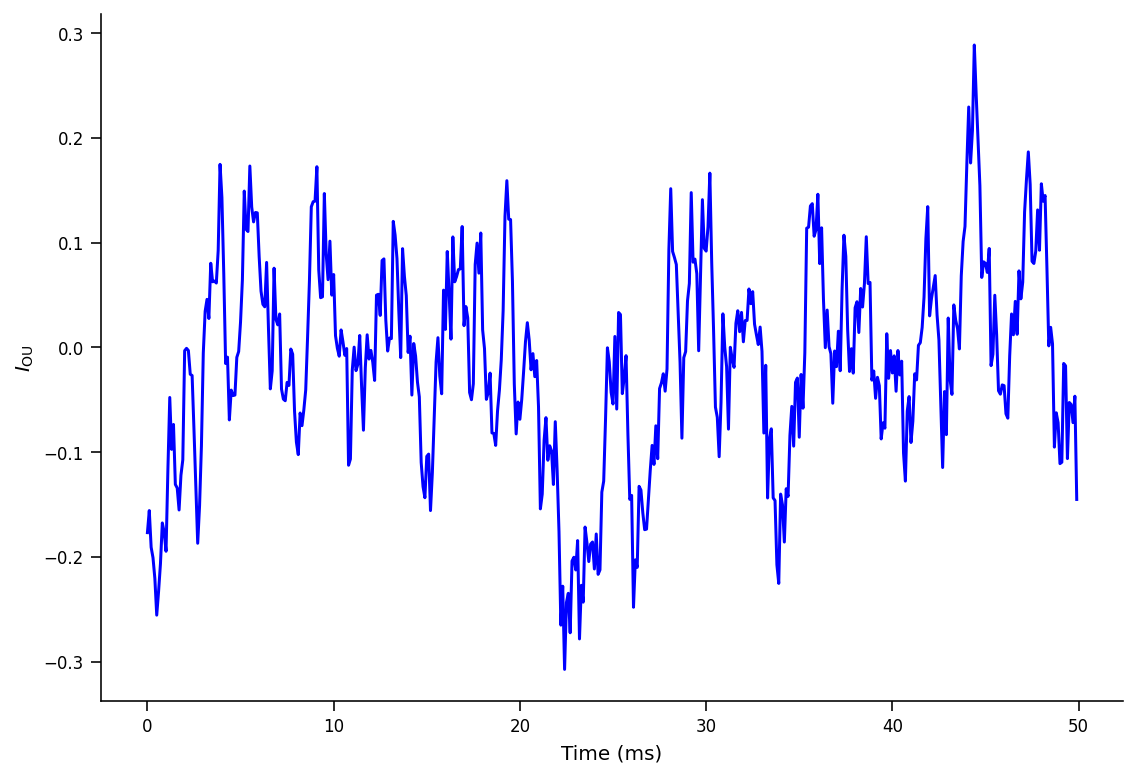

In [18]:
# @markdown Make sure you execute this cell to enable the function my_OU and plot the input current!


def my_OU(pars, sig, myseed=False):
  """
  Expects:
  pars       : parameter dictionary
  sig        : noise amplitute
  myseed     : random seed. int or boolean

  Returns:
  I          : Ornstein-Uhlenbeck input current
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou']  # [ms]

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # Initialize
  noise = np.random.randn(Lt)
  I_ou = np.zeros(Lt)
  I_ou[0] = noise[0] * sig

  # generate OU
  for it in range(Lt-1):
      I_ou[it+1] = (I_ou[it]
                    + dt / tau_ou * (0. - I_ou[it])
                    + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1])
  return I_ou


pars = default_pars(T=50)
pars['tau_ou'] = 1.  # [ms]
sig_ou = 0.1
I_ou = my_OU(pars, sig=sig_ou, myseed=2020)
plt.figure(figsize=(8, 5.5))
plt.plot(pars['range_t'], I_ou, 'b')
plt.xlabel('Time (ms)')
plt.ylabel(r'$I_{\mathrm{OU}}$')
plt.show()



With the default parameters, the system fluctuates around a resting state with the noisy input.


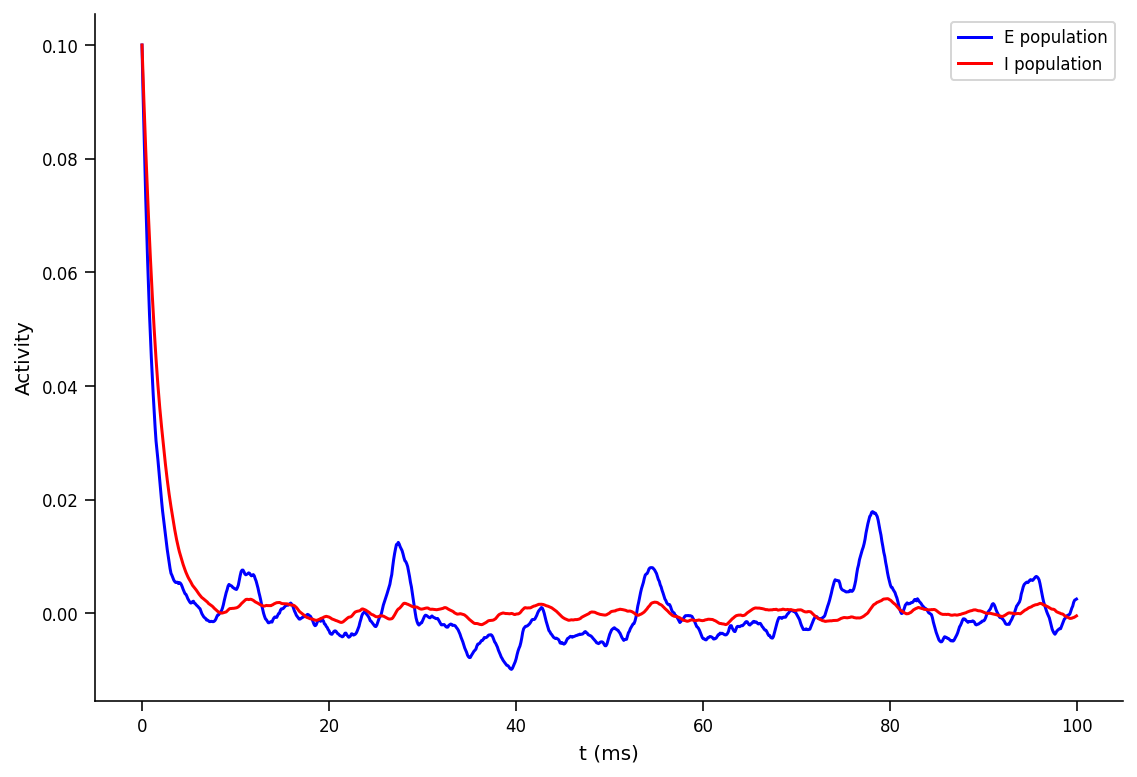

In [19]:
# @markdown Execute this cell to plot activity with noisy input current
pars = default_pars(T=100)
pars['tau_ou'] = 1.  # [ms]
sig_ou = 0.1
pars['I_ext_E'] = my_OU(pars, sig=sig_ou, myseed=20201)
pars['I_ext_I'] = my_OU(pars, sig=sig_ou, myseed=20202)

pars['rE_init'], pars['rI_init'] = 0.1, 0.1
rE, rI = simulate_wc(**pars)

plt.figure(figsize=(8, 5.5))
ax = plt.subplot(111)
ax.plot(pars['range_t'], rE, 'b', label='E population')
ax.plot(pars['range_t'], rI, 'r', label='I population')
ax.set_xlabel('t (ms)')
ax.set_ylabel('Activity')
ax.legend(loc='best')
plt.show()

## Interactive Demo 3: Short pulse induced persistent activity
Then, let's use a brief 10-ms positive current to the E population when the system is at its equilibrium. When this amplitude (SE below) is sufficiently large, a persistent activity is produced that outlasts the transient input. What is the firing rate of the persistent activity, and what is the critical input strength? Try to understand the phenomena from the above phase-plane analysis.

In [20]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def my_inject(pars, t_start, t_lag=10.):
  """
  Expects:
  pars       : parameter dictionary
  t_start    : pulse starts [ms]
  t_lag      : pulse lasts  [ms]

  Returns:
  I          : extra pulse time
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Initialize
  I = np.zeros(Lt)

  # pulse timing
  N_start = int(t_start / dt)
  N_lag = int(t_lag / dt)
  I[N_start:N_start + N_lag] = 1.

  return I


pars = default_pars(T=100)
pars['tau_ou'] = 1.  # [ms]
sig_ou = 0.1
pars['I_ext_I'] = my_OU(pars, sig=sig_ou, myseed=2021)
pars['rE_init'], pars['rI_init'] = 0.1, 0.1

# pulse
I_pulse = my_inject(pars, t_start=20., t_lag=10.)
L_pulse = sum(I_pulse > 0.)


def WC_with_pulse(SE=0.):
  pars['I_ext_E'] = my_OU(pars, sig=sig_ou, myseed=2022)
  pars['I_ext_E'] += SE * I_pulse

  rE, rI = simulate_wc(**pars)

  plt.figure(figsize=(8, 5.5))
  ax = plt.subplot(111)
  ax.plot(pars['range_t'], rE, 'b', label='E population')
  ax.plot(pars['range_t'], rI, 'r', label='I population')

  ax.plot(pars['range_t'][I_pulse > 0.], 1.0*np.ones(L_pulse), 'r', lw=3.)
  ax.text(25, 1.05, 'stimulus on', horizontalalignment='center',
          verticalalignment='bottom')
  ax.set_ylim(-0.03, 1.2)
  ax.set_xlabel('t (ms)')
  ax.set_ylabel('Activity')
  ax.legend(loc='best')
  plt.show()


_ = widgets.interact(WC_with_pulse, SE=(0.0, 1.0, .05))

interactive(children=(FloatSlider(value=0.0, description='SE', max=1.0, step=0.05), Output()), _dom_classes=('…

In [ ]:
# to_remove explanation

"""
Discussion:

When a system has more than one fixed points, depending on the input strength,
the network will settle in one of the fixed points. In this case, we have two
fixed points, one of the fixed points corresponds to high activity. So when input
drives the network to the high activity fixed points, the network activity will
remain there -- it is a stable fixed point. Because the network retains its
activity (persistent activity) even after the input has been removed, we can
take the persistent activity as working memory.
""";

Explore what happens when a second, brief current is applied to the inhibitory population. 